# **Import necessary libraries**

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!pip install scikit-learn==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.0
    Uninstalling numpy-2.0.0:
      Successfully uninstalled numpy-2.0.0


In [ ]:
!pip show joblib

Name: joblib
Version: 1.4.2
Summary: Lightweight pipelining with Python functions
Home-page: 
Author: 
Author-email: Gael Varoquaux <gael.varoquaux@normalesup.org>
License: BSD 3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: imbalanced-learn, librosa, mlxtend, music21, nltk, scikit-learn


In [52]:
import os   # Operating system interactions
import pandas as pd  # Data manipulation and analysis
import numpy as np
import csv   # CSV file handling
from scipy import stats # Statistical functions
import pywt  # Wavelet transform for signal processing (if needed)
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.decomposition import PCA #PCA
from sklearn.preprocessing import StandardScaler #StandardScaler
from sklearn.ensemble import RandomForestClassifier #RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier #DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression #LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score , roc_auc_score, roc_curve, auc# Model evaluation metrics
import joblib # For model persistence
# Warning handling
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings (use with caution)

# **Read MITBIH database**

In [53]:
path = '/content/drive/MyDrive/CheckBox/mitbih_database/'
window_size = 190
maximum_counting = 10000

classes = ['N','A','V','F','/']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [54]:
def read_and_separate_files(path):
  """
  Reads files from a directory, separating them by '.csv' and '.txt' extensions.

  Args:
    path: The path to the directory containing the files.

  Returns:
    A tuple containing two lists:
      - A list of paths to '.csv' files.
      - A list of paths to '.txt' files.
  """

  csv_files = []
  txt_files = []

  for filename in sorted(os.listdir(path)):
    file_path = os.path.join(path, filename)

    if filename.endswith('.csv'):
      csv_files.append(file_path)
    elif filename.endswith('.txt'):
      txt_files.append(file_path)

  return csv_files, txt_files

# Example usage:
records, annotations = read_and_separate_files(path)

In [55]:
print("no.of annotation files is : ",len(annotations))
print("no.of records is : " ,len(records))

no.of annotation files is :  48
no.of records is :  48


In [56]:
records

['/content/drive/MyDrive/CheckBox/mitbih_database/100.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/101.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/102.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/103.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/104.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/105.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/106.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/107.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/108.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/109.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/111.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/112.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/113.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/114.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/115.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/116.csv',
 '/content/drive/MyDrive/CheckBox/mitbih

In [57]:
annotations

['/content/drive/MyDrive/CheckBox/mitbih_database/100annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/101annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/102annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/103annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/104annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/105annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/106annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/107annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/108annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/109annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/111annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/112annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/113annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/114annotations.txt',
 '/con

# **Data Preprocessing and Extraction**

In [58]:
def denoise_fun(data, wavelet='sym4', threshold=0.04):
  """
  Denoises a signal using wavelet thresholding.

  Args:
    data: The input signal as a 1D array-like object.
    wavelet: The name of the wavelet to use. Defaults to 'sym4'.
    threshold: The threshold value for filtering. Defaults to 0.04.

  Returns:
    The denoised signal as a 1D array.
  """

  # Determine the maximum decomposition level
  w = pywt.Wavelet(wavelet)
  maxlev = pywt.dwt_max_level(len(data), w.dec_len)

  # Perform wavelet decomposition
  coeffs = pywt.wavedec(data, wavelet, level=maxlev)

  # Apply thresholding to detail coefficients
  for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold * max(abs(coeffs[i])), mode='soft')

  # Reconstruct the signal from the modified coefficients
  datarec = pywt.waverec(coeffs, wavelet)

  return datarec

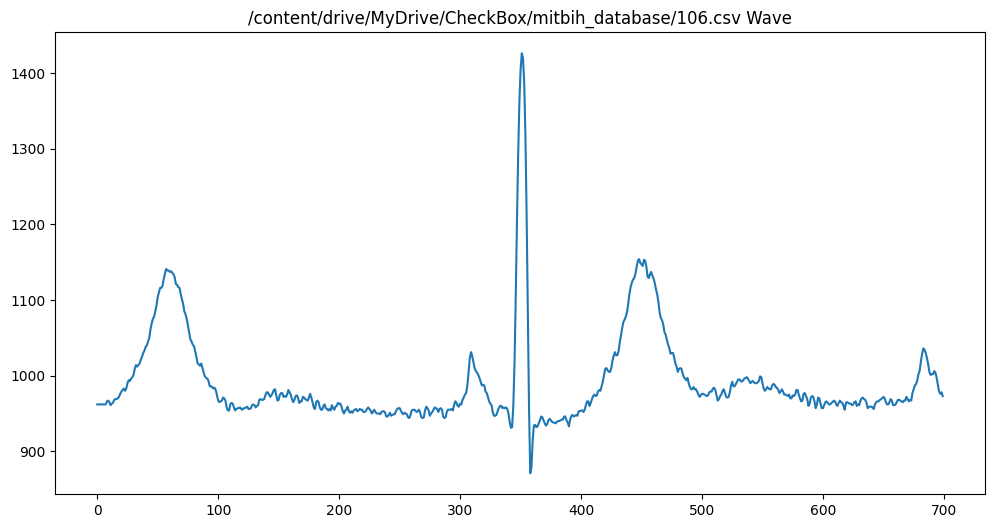

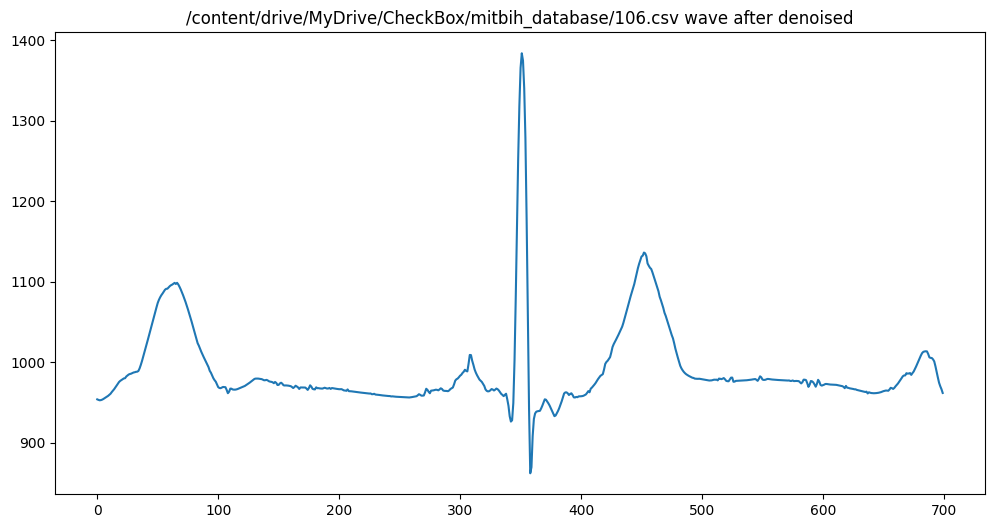

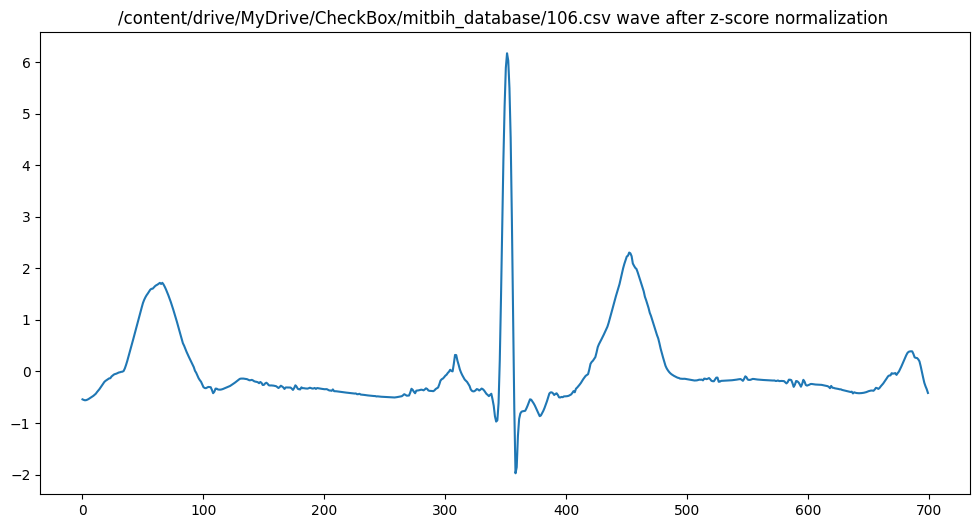

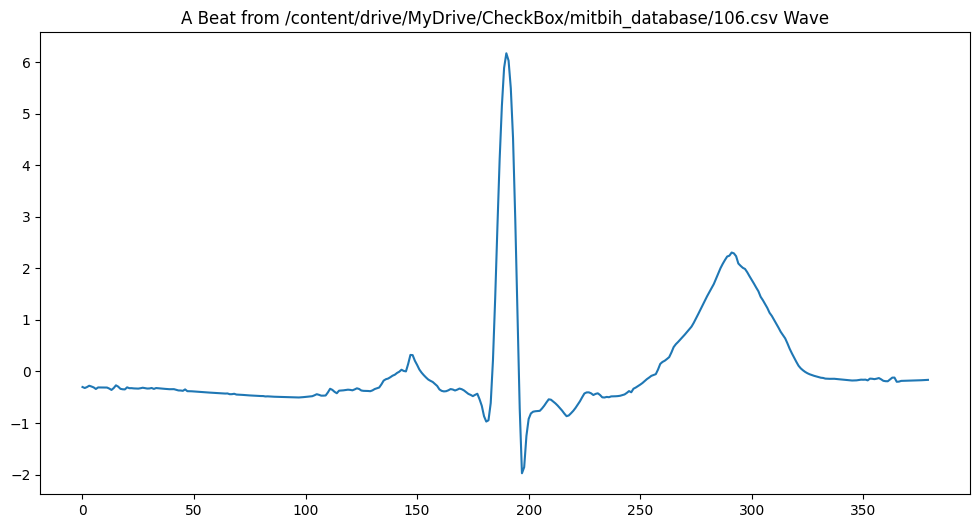

(92508, 380) (92508,)


In [59]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV files
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.figure(figsize=(12, 6))
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise_fun(signals)
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.figure(figsize=(12, 6))
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.figure(figsize=(12, 6))
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]
                    # Plot an example to a beat
                    if r is 6 and not example_beat_printed:
                        plt.figure(figsize=(12, 6))
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [60]:
for i in range(0,len(X)):
        X[i] = np.append (X[i],y[i])

print(np.shape(X))

(92508, 381)


# **EXPLORATORY DATA ANALYTICS**

In [61]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

380
0.0    75008
2.0     7129
4.0     7023
1.0     2546
3.0      802
Name: count, dtype: int64


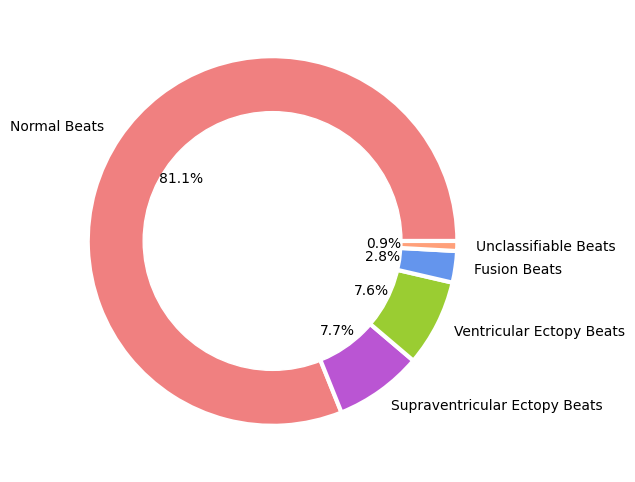

In [62]:
def create_class_distribution_pie_chart(data, class_column_index, custom_colors=None):
  """
  Creates a pie chart visualizing the class distribution in a DataFrame.

  Args:
    data: The input DataFrame.
    class_column_index: The index of the column containing class labels.
    custom_colors: (Optional) A list of colors to use for the pie slices.
                   If None, default colors will be used.
  """

  class_counts = data.iloc[:, class_column_index].value_counts()

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed

  # Create a white circle in the center for a donut chart effect
  my_circle = plt.Circle((0, 0), 0.7, color='white')

  plt.pie(class_counts,
          labels=['Normal Beats','Supraventricular Ectopy Beats','Ventricular Ectopy Beats','Fusion Beats','Unclassifiable Beats'],
          colors=custom_colors,
          autopct='%1.1f%%',
          wedgeprops={'linewidth': 3, 'edgecolor': 'white'})  # Add white border to slices

  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

# Example usage with custom colors:
my_colors = ['#F08080', '#BA55D3', '#9ACD32', '#6495ED', '#FFA07A']
create_class_distribution_pie_chart(X_train_df, X_train_df.shape[1] - 1, my_colors)

In [63]:
X_train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
376    0
377    0
378    0
379    0
380    0
Length: 381, dtype: int64

In [64]:
X_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
count,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,...,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000,92508.000000
mean,-0.028849,-0.036192,-0.042226,-0.046775,-0.050468,-0.053624,-0.056139,-0.057941,-0.059499,-0.061021,...,-0.020165,-0.017058,-0.014179,-0.011632,-0.009138,-0.006807,-0.004399,-0.001914,0.001079,0.511329
std,0.936377,0.929260,0.923292,0.917601,0.912855,0.909268,0.906824,0.905106,0.902547,0.898926,...,0.835042,0.846758,0.858528,0.870229,0.881782,0.893601,0.905748,0.918758,0.933355,1.169207
min,-12.384485,-12.355621,-12.286844,-12.311547,-12.355870,-12.349130,-12.328730,-12.317792,-12.307292,-12.296405,...,-11.674607,-11.671838,-11.670768,-11.670284,-11.668173,-11.665714,-11.663233,-11.661117,-11.717839,0.000000
25%,-0.484667,-0.484877,-0.485424,-0.483826,-0.484150,-0.482464,-0.480333,-0.478935,-0.476838,-0.474642,...,-0.335064,-0.336200,-0.336369,-0.337147,-0.337646,-0.337731,-0.337712,-0.339017,-0.340223,0.000000
50%,-0.160442,-0.161371,-0.163132,-0.163143,-0.163696,-0.163442,-0.162314,-0.161558,-0.161052,-0.160141,...,-0.099936,-0.099452,-0.099291,-0.099598,-0.099884,-0.098934,-0.098428,-0.099397,-0.100073,0.000000
75%,0.241606,0.232765,0.226517,0.220345,0.214861,0.209756,0.204553,0.200321,0.196310,0.192094,...,0.152168,0.154184,0.156460,0.159060,0.161361,0.164123,0.166986,0.169905,0.173045,0.000000
max,13.716679,13.730527,13.638237,13.591825,13.552887,13.574854,13.624557,13.717565,13.627718,13.571292,...,11.044259,10.899663,10.882439,10.883672,10.871012,10.941076,10.857770,10.858049,10.852959,4.000000


In [65]:
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0,-0.096772,-0.089818,-0.082172,-0.075746,-0.068587,-0.065934,-0.064644,-0.046454,-0.024079,-0.022218,...,-0.077880,-0.059478,-0.066300,-0.071428,-0.073830,-0.074861,-0.076748,-0.078618,-0.080187,0.0
1,-0.574888,-0.557184,-0.538115,-0.516919,-0.495458,-0.471834,-0.442075,-0.437039,-0.394146,-0.370450,...,-0.160705,-0.152649,-0.161554,-0.151070,-0.144279,-0.135573,-0.133466,-0.133821,-0.135692,0.0
2,-0.350465,-0.337540,-0.322610,-0.308907,-0.294811,-0.279687,-0.263878,-0.246500,-0.228240,-0.210995,...,-0.005387,-0.004141,-0.002755,-0.001210,0.002676,0.007514,0.011845,0.016963,0.021060,0.0
3,-0.213775,-0.210162,-0.207348,-0.205387,-0.200431,-0.194591,-0.198780,-0.205502,-0.199403,-0.189890,...,0.110741,0.106114,0.099279,0.110227,0.125628,0.117773,0.103875,0.104245,0.108137,0.0
4,-0.367812,-0.365467,-0.363633,-0.361438,-0.360380,-0.358482,-0.352131,-0.344650,-0.330972,-0.314733,...,-0.009315,-0.005195,-0.001428,0.000641,0.001741,0.003120,0.004067,0.003187,0.002683,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92503,-0.644439,-0.620151,-0.594378,-0.569960,-0.554830,-0.543998,-0.535372,-0.526177,-0.522423,-0.531266,...,-0.531411,-0.489481,-0.429062,-0.390058,-0.353451,-0.337167,-0.322857,-0.276526,-0.212939,0.0
92504,-0.741245,-0.740153,-0.728802,-0.709858,-0.685871,-0.677537,-0.671330,-0.650289,-0.624197,-0.595021,...,-0.483924,-0.473008,-0.458425,-0.443130,-0.421923,-0.399675,-0.396221,-0.398628,-0.387200,0.0
92505,-0.602727,-0.583496,-0.562950,-0.561624,-0.558137,-0.591100,-0.566598,-0.562155,-0.553818,-0.549506,...,-0.380004,-0.386308,-0.379537,-0.377091,-0.368537,-0.356864,-0.337603,-0.313191,-0.287486,0.0
92506,-0.583730,-0.571780,-0.563409,-0.557250,-0.552568,-0.546992,-0.542321,-0.534446,-0.526035,-0.530337,...,-0.331812,-0.296069,-0.281879,-0.267935,-0.256046,-0.240658,-0.195561,-0.138409,-0.086842,0.0


In [66]:
y

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


**PCA DIMENSIONALITY REDUCTION TECHNIQUE**

In [67]:
# 1. Standardize the Data (Important for PCA)
scaler = StandardScaler()
balanced_records_scaled = scaler.fit_transform(X_train_df)

# 2. Apply PCA
pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
balanced_records_reduced = pca.fit_transform(balanced_records_scaled)

# 3. Create a New DataFrame (Optional)
balanced_records_reduced_df = pd.DataFrame(balanced_records_reduced)

# Print shapes and explained variance
print("Reduced DataFrame shape:", balanced_records_reduced_df.shape)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

Reduced DataFrame shape: (92508, 21)
Explained Variance Ratio: [0.39862135 0.13635059 0.07298763 0.06453281 0.04537959 0.04024096
 0.02801048 0.02395514 0.02067919 0.01993269 0.01703482 0.01498079
 0.01261553 0.0107003  0.00869758 0.00823975 0.00746087 0.00701653
 0.00563648 0.00542746 0.00456225]
Total Explained Variance: 0.953062796312884


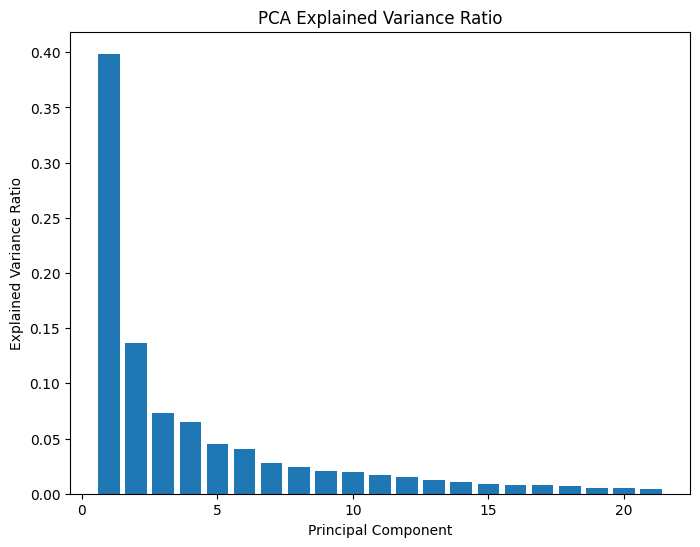

In [103]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [68]:
balanced_records_reduced_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.274932,-5.737416,3.479501,0.832020,-0.284037,2.086002,1.122854,1.282849,-4.632274,1.707135,...,0.600199,0.251192,-0.221551,-0.241100,-0.939056,-0.277285,-0.619510,0.707994,0.398192,0.231000
1,-2.320499,-2.489193,2.538815,-0.153663,-1.223096,1.700753,0.200993,0.262311,-3.738127,-0.325901,...,-0.664833,-0.139659,-1.297041,1.507086,-0.222724,-0.836765,0.732134,0.376955,-0.044246,0.197319
2,-2.353375,-0.537454,2.973167,-0.240514,0.502194,2.249614,1.172202,1.536815,-5.144672,1.895091,...,-0.989191,0.604652,-0.845994,0.233324,-0.694747,0.006703,-0.479030,0.679197,0.127583,0.327603
3,-0.876485,-3.910620,2.469118,-0.940675,0.186245,1.686344,0.480387,0.510683,-3.135635,1.759146,...,-2.074008,-0.118314,-1.212778,1.313887,0.261873,-0.840847,0.741663,0.011266,0.045917,0.081851
4,-0.805492,-3.928909,2.742307,-0.446731,-1.304805,1.983859,0.263880,0.259776,-3.027159,1.329245,...,-1.157550,-0.614263,-0.304671,1.329638,-0.188961,-1.476629,1.242567,-0.087556,0.422627,-0.046751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92503,-8.125489,-2.148991,2.068241,-0.678183,-0.067434,-1.081029,0.469315,0.345927,-2.645099,-1.246218,...,-0.338445,1.453464,-1.204730,0.829398,-0.100853,-0.340588,0.159032,0.318577,-0.139340,0.079057
92504,-9.350690,-3.252102,1.777183,0.037155,0.025538,0.480069,0.537529,0.267433,-2.459070,-1.106294,...,-0.441071,1.839449,-1.518114,0.723626,-1.039518,0.019696,-0.480071,0.877804,-0.337138,0.573370
92505,-9.817605,-2.115679,1.917013,-1.083378,-0.139356,0.246524,-0.100288,0.209805,-2.205539,-0.065273,...,-0.351885,1.398692,-1.166981,0.609742,-0.602126,-0.500161,-0.038932,0.513100,-0.310063,0.275652
92506,-8.198265,-1.566353,1.241344,-1.509664,0.014295,0.145245,-0.226033,0.155662,-1.749917,-0.498873,...,0.347410,1.162561,-0.249362,0.232602,-0.385166,-0.453908,0.090811,0.289750,0.173401,0.106907


In [69]:
balanced_records_reduced_df.shape

(92508, 21)

# **Model Building and Evaluation**

**Spliting the Train and Test data**

In [70]:
X_train,X_test,y_train, y_test = train_test_split(balanced_records_reduced_df,y, test_size=0.2)
print("X_train : ", np.shape(X_train))
print("X_test  : ", np.shape(X_test))

X_train :  (74006, 21)
X_test  :  (18502, 21)


**Random Forest Model Developement**

In [88]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

# Train the classifier using extracted features and corresponding labels
rf_classifier.fit(X_train, y_train)

# Predict labels for validation data
y_pred_valid = rf_classifier.predict(X_test)



**Random Forest Model Evaluation**

In [89]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_valid)
f1 = f1_score(y_test, y_pred_valid, average='macro')  # Use 'macro' for multi-class
precision = precision_score(y_test, y_pred_valid, average='macro')
recall = recall_score(y_test, y_pred_valid, average='macro')

# ROC-AUC requires probability scores for multi-class
y_pred_proba = rf_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 'ovr' for multi-class

# Print metrics
print("Random Forest Classifier Accuracy:", accuracy)
print("Random Forest Classifier F1 Score:", f1)
print("Random Forest Classifier Precision:", precision)
print("Random Forest Classifier Recall:", recall)
print("Random Forest Classifier ROC-AUC:", roc_auc)

Random Forest Classifier Accuracy: 0.9818398011025835
Random Forest Classifier F1 Score: 0.8765815952864611
Random Forest Classifier Precision: 0.9767524555415408
Random Forest Classifier Recall: 0.8217090407889069
Random Forest Classifier ROC-AUC: 0.9879667396161139


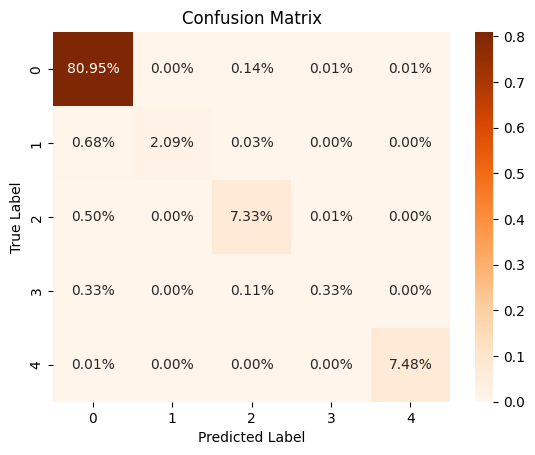

<Figure size 640x480 with 0 Axes>

In [73]:
cm = confusion_matrix(y_test, y_pred_valid)
sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('Confusion_matrice_rf.png')

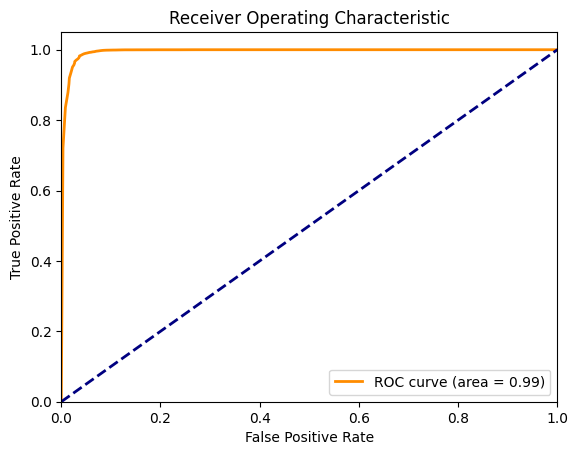

In [100]:
#ROC Curve and AUC
y_prob = rf_classifier.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Decision Tree Classifier Model Development**

In [107]:
# Create the Decision Tree classifier
clf_dt = DecisionTreeClassifier(random_state=42)

# Train the classifier on the normalized training data
clf_dt.fit(X_train, y_train)

# Make predictions on the normalized validation set
y_pred_valid = clf_dt.predict(X_test)


**Decision Tree Classifier Model Evaluation**



In [108]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_valid)
f1 = f1_score(y_test, y_pred_valid, average='macro')  # Use 'macro' for multi-class
precision = precision_score(y_test, y_pred_valid, average='macro')
recall = recall_score(y_test, y_pred_valid, average='macro')

# ROC-AUC requires probability scores for multi-class
y_pred_proba = rf_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 'ovr' for multi-class

# Print metrics
print("Decision Tree Classifier Accuracy:", accuracy)
print("Decision Tree Classifier F1 Score:", f1)
print("Decision Tree Classifier Precision:", precision)
print("Decision Tree Classifier Recall:", recall)
print("Decision Tree Classifier ROC-AUC:", roc_auc)

Decision Tree Classifier Accuracy: 0.9612474327099773
Decision Tree Classifier F1 Score: 0.8132963051359654
Decision Tree Classifier Precision: 0.8085340202456518
Decision Tree Classifier Recall: 0.819223328659843
Decision Tree Classifier ROC-AUC: 0.9879667396161139


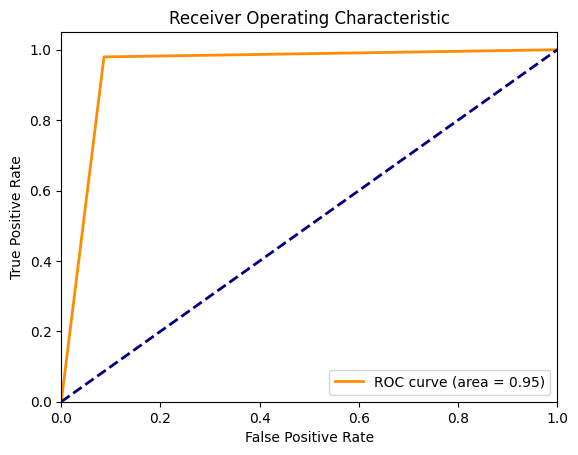

In [109]:
#ROC Curve and AUC

y_prob = clf_dt.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

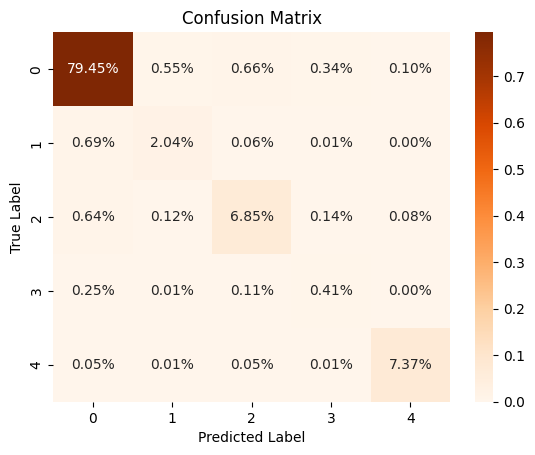

<Figure size 640x480 with 0 Axes>

In [76]:
cm = confusion_matrix(y_test, y_pred_valid)
sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('Confusion_matrice_dc.png')

**LogisticRegression Model Development**

In [110]:
lin_reg=LogisticRegression()
lin_reg.fit(X_train, y_train)
y_pred_valid = lin_reg.predict(X_test)


**LogisticRegression Model Evaluation**

In [111]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_valid)
f1 = f1_score(y_test, y_pred_valid, average='macro')  # Use 'macro' for multi-class
precision = precision_score(y_test, y_pred_valid, average='macro')
recall = recall_score(y_test, y_pred_valid, average='macro')

# ROC-AUC requires probability scores for multi-class
y_pred_proba = rf_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 'ovr' for multi-class

# Print metrics
print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1 Score:", f1)
print("Logistic Regression Precision:", precision)
print("Logistic Regression Recall:", recall)
print("Logistic Regression ROC-AUC:", roc_auc)

Logistic Regression Accuracy: 0.9217381904658956
Logistic Regression F1 Score: 0.6557782833950002
Logistic Regression Precision: 0.7602820980092874
Logistic Regression Recall: 0.6083178067240842
Logistic Regression ROC-AUC: 0.9879667396161139


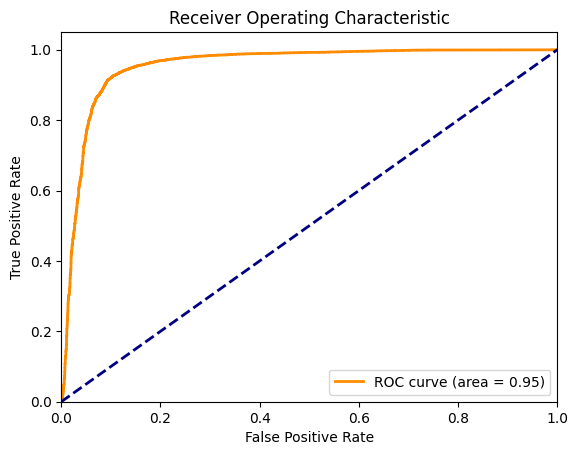

In [112]:
#ROC Curve and AUC
y_prob = lin_reg.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

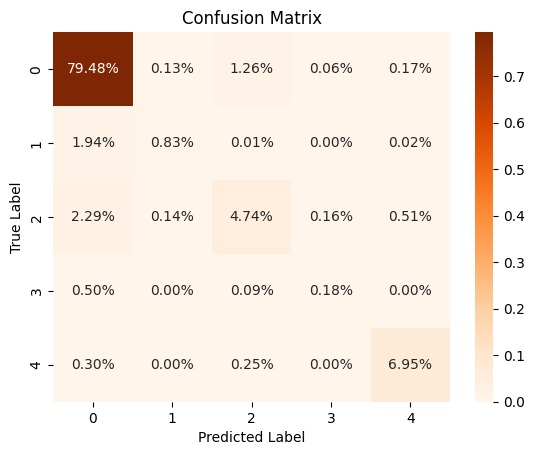

<Figure size 640x480 with 0 Axes>

In [79]:
cm = confusion_matrix(y_test, y_pred_valid)
sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('Confusion_matrice_lg.png')

# **SAVE MODEL**

In [80]:
rf_classifier.fit(X_train, y_train)
filename = 'ecg_pred.pkl'
joblib.dump(rf_classifier, filename)

['ecg_pred.pkl']

In [81]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9818398011025835
